## Install and import packages

In [5]:
# !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install scikit-learn
!pip3 install tqdm
!pip3 install transformers
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 58.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Read data

The dataset we are going to use in this notebook is the *[BBC News Classification dataset](http://mlg.ucd.ie/datasets/bbc.html)*. You can download the dataset in [Kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

In [7]:
import pandas as pd

In [25]:
df = pd.read_csv('../data/processed/hein-daily_114.csv', names = ['speech','party'], header=None)
# df = pd.read_csv('./data/bbc-text-small.csv') # smaller dataset to save training time.

In [77]:
df.head(5)

,speech,party
1,RODGERS. Madam Clerk. it is an honor to addres...,R
2,Madam Clerk. first I would like to recognize e...,D
3,Madam Clerk. I present for election to the off...,R
4,Madam Clerk. I present for the election of the...,R
5,Madam Clerk. I rise to place in a nomination f...,R


This dataset is in CSV format and it has 2126 different texts, each labeled under one of 5 categories: entertainment, sport, tech, business, or politics. It has two columns, **category** which will be the label; and **text** which will be our input data for GPT-2.

In [28]:
df = df[1:48513]

In [75]:
df.speech.str.split().apply(len).sort_values()
' '.join(df.loc[6057].speech.split()[:128])

'Mr. President. I am reading the book "Half the Sky." by Nicholas D. Kristof and Sheryl WuDunn. I think it is a beautiful book. It is on sex trafficking around the world and what has been happening around the world. A part of this is that I think we need to make the point that we can lead in our country when it comes to sex trafficking. We have Senator CORNYNs bill. and we know there is an issue with one of the provisions that needs to be resolvedand I dont think it is a provision that is related to this topicbut we are hopeful people of good will can come together and resolve this issue. The easiest way would be to take it out. We can have'

<AxesSubplot: xlabel='party'>

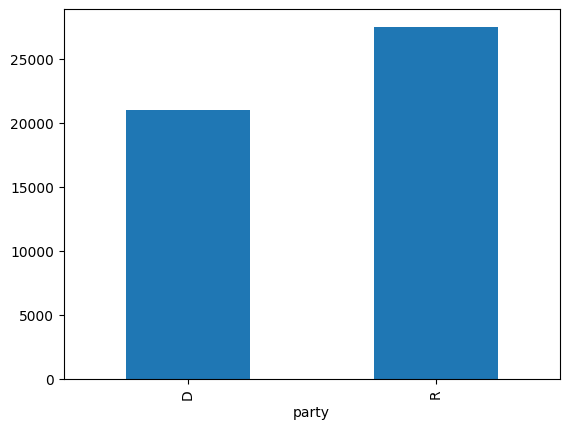

In [29]:
df.groupby("party").size().plot.bar()

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [13]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [14]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [15]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [16]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [17]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


## Dataset class

PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training. See more details [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Here we will build a custom Dataset class to read in our news data, tokenize them, and store them into containers for batch training.

In [30]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "D": 0,
    "R": 1
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['party']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['speech']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [31]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

38809 4851 4852


## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [32]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [39]:
train, val = Dataset(df_train), Dataset(df_val)
    
train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

In [41]:
def train(model, learning_rate, epochs):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(df_train): .3f} \
            | Train Accuracy: {total_acc_train / len(df_train): .3f} \
            | Val Loss: {total_loss_val / len(df_val): .3f} \
            | Val Accuracy: {total_acc_val / len(df_val): .3f}")
            
EPOCHS = 3
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, LR, EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2426/2426 [04:49<00:00,  8.39it/s]


Epochs: 1 | Train Loss:  0.039             | Train Accuracy:  0.651             | Val Loss:  0.033             | Val Accuracy:  0.715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2426/2426 [04:49<00:00,  8.37it/s]


Epochs: 2 | Train Loss:  0.029             | Train Accuracy:  0.767             | Val Loss:  0.029             | Val Accuracy:  0.756


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2426/2426 [04:49<00:00,  8.38it/s]


Epochs: 3 | Train Loss:  0.020             | Train Accuracy:  0.855             | Val Loss:  0.031             | Val Accuracy:  0.768


Looks like the model is already well trained after 1 epoch! This is probably due to the fact that as a pre-trained model with gigantic number of parameters, GPT-2 is already capable of differentiating different text paragraphs without too much tuning.

## Evaluation

After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the `evaluate` function according [this PyTorch guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [42]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.756


Another good gauge of model performance is the confusion matrix.

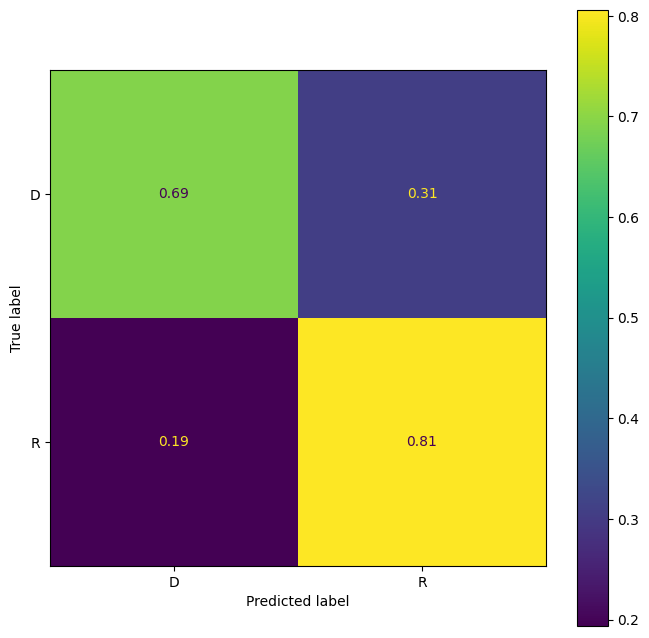

In [43]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model

After training, we need to save the model locally. PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [45]:
# save trained model
torch.save(model.state_dict(), "../model/gpt2-text-classifier-model.pt")

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In [46]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("../model/gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dr

## Model Inference

Here we want to use the model to generate inferences. Here we use a clipped news from [BBC Politics](https://www.bbc.com/news/uk-60095459) as an example.

In [53]:
example_text = """
Although I do support the changes to our ethics rules contained in the package. I cannot support the overall package. and I rise in opposition to the previous question for the purposes of allowing the House to consider a constitutional amendment to address the Supreme Courts decision in Citizens United. The 2012 election was the most expensive in our Nations history. Outside groups. including over 1.200 super PACs spent $970 million. and $123 million of anonymous cash was spent in our campaigns. All told. the price tag for last years election was $6 billion. This is only the beginning. In the years to come. spending will expand at the Federal. State. and local levelsmegaphones of monied interests drowning out the voices of ordinary Americans. Its time for us to do something about it. And I dont take amending our Constitution. our founding document. lightly. And here on this day. when were celebrating and commemorating this years 150th anniversary of the signing of the Emancipation Proclamation. its time for all Americans to be free in our elections. to free our elections from monied interests. and to amend the Constitution so that Congress can protect the integrity of our elections.
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

although i do support the changes to our ethics rules contained in the package. i cannot support the overall package. and i rise in opposition to the previous question for the purposes of allowing the house to consider a constitutional amendment to address the supreme courts decision in citizens united. the 2012 election was the most expensive in our nations history. outside groups. including over 1.200 super pacs spent $970 million. and $123 million of anonymous cash was spent in our campaigns. all told. the price tag for last years election was $6 billion. this is only the beginning. in the years to come. spending will expand at the federal. state. and local levelsmegaphones of monied interests drowning out the voices of ordinary americans. its time for us to do something about it. and i dont take amending our constitution. our founding document. lightly. and here on this day. when were celebrating and commemorating this years 150th anniversary of the signing of the emancipation proc

After text tokenization, we need to extract two inputs for the model, `input_id` and `mask`. 

In [54]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [55]:
print(output)

tensor([[ 0.4418, -0.7464]], grad_fn=<AddmmBackward0>)


The output here is the model output for each label. We can normalize them as probabilities using Softmax algorithm.

In [56]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [57]:
print(prob)

tensor([0.7664, 0.2336], grad_fn=<SelectBackward0>)


Let's see if our predictor can correctly classify this news as "politics".

In [58]:
labels_map = {
    0: "D",
    1: "R"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

D


It can!

## Clear cache

If you are using PyTorch's CUDA version, remember to clear cache after running this notebook to avoid re-run issues.

In [78]:
torch.cuda.empty_cache()